# Машинное обучение, ФКН ВШЭ

# Практическое задание 7. Бустинговое


## О задании

В этом задании вам предстоит вручную запрограммировать один из самых мощных алгоритмов машинного обучения — бустинг.

In [19]:
from warnings import filterwarnings

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy.sparse import load_npz
from sklearn.model_selection import train_test_split


sns.set(style='darkgrid')
filterwarnings('ignore')

In [20]:
x = load_npz('x.npz')
y = np.load('y.npy')

Разделим на обучающую, валидационную и тестовую выборки (`random_state` оставьте равным 1337 для воспроизводимости).

In [21]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=1337)

x_test, x_valid, y_test, y_valid = train_test_split(x_test, y_test, test_size=0.5, random_state=1337)

x_train.shape, x_valid.shape, x_test.shape

((18825, 169), (2354, 169), (2353, 169))

## Задание 1. Реализация градиентного бустингового (4 балла)

Вам нужно дописать код в файлике `boosting.py`. Для вас уже подготовлен шаблон класса `Boosting`, вы можете менять его по своему усмотрению.

### Инструкции для функций:

#### `__init__`

В `__init__` приходит кучка параметров, распишем что есть что:

 - `base_model_class` - класс базовой модели нашего бустинга
 - `base_model_params` - словарь с гиперпараметрами для базовой модели
 - `n_estimators` - какое количество базовых моделей нужно обучить
 - `learning_rate` - темп обучения, должен быть из полуинтервала $(0, 1]$
 - `subsample` - доля объектов, на которой будет обучаться базовая модель (какую часть составляет бутстрапная выборка от исходной обучающей)
 - `early_stopping_rounds` - число итераций, после которых при отсутствии улучшения качества на валидационной выборке обучение останавливается
 - `plot` - строить ли после обучения всех базовых моделей график с качеством

#### `fit`

В `fit` приходит две выборки, обучающая и валидационная. На обучающей мы обучаем новые базовые модели, на валидационной считаем качество для ранней остановки (если это предусматривают параметры).

Сначала нам нужно сделать какую-то нулевую модель, сделать предсказания для обучающей и валидационной выборок (в шаблоне это нулевая модель, соответственно предсказания это просто `np.zeros`). После этого нужно обучить `n_estimators` базовых моделей (как и на что обучаются базовые модели смотрите в лекциях и семинарах). После каждой обученной базовой модели мы должны обновить текущие предсказания, посчитать ошибку на обучающей и валидационной выборках (используем `loss_fn` для этого), проверить на раннюю остановку.

После всего цикла обучения надо нарисовать график (если `plot`).


#### `fit_new_base_model`

В `fit_new_base_model` приходит обучающая выборка (целиком) и текущие предсказания для неё. Мы должны сгенерировать бутстрап выборку для обучения базовой модели и обучить базовую модель. После обучения модели запускаем поиск оптимальной гаммы, добавляем новую модель и гамму (не забываем про темп обучения) в соответствующие списки.

#### `predict_proba`

В `predict_proba` приходит выборка, нужно предсказать вероятности для неё. Суммируем предсказания базовых моделей на этой выборке (не забываем про гаммы) и накидываем сигмоиду.

In [22]:
%load_ext autoreload

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [23]:
%autoreload 2

from boosting import Boosting

### Проверка кода

У автора задания всё учится около одной секунды.

In [24]:
boosting = Boosting()

%time boosting.fit(x_train, y_train, x_valid, y_valid)

assert len(boosting.models) == boosting.n_estimators
assert len(boosting.gammas) == boosting.n_estimators

assert boosting.predict_proba(x_test).shape == (x_test.shape[0], 2)

print(f'Train ROC-AUC {boosting.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {boosting.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {boosting.score(x_test, y_test):.4f}')

CPU times: user 371 ms, sys: 98 μs, total: 371 ms
Wall time: 371 ms
Train ROC-AUC 0.9885
Valid ROC-AUC 0.9210
Test ROC-AUC 0.9210


## Задание 2. Обучение градиентного бустингового (1 балл)

Оцените качество на тестовой выборке вашей имплементации бустинга для различной максимальной глубины решающего дерева в качестве базовой модели. Здесь и далее мы будем использовать метрику ROC-AUC.

Перебирайте максимальную глубину от 1 до 30 с шагом 2 (остальные параметры бустинга стоит оставить равными по умолчанию). Постройте график зависимости качества на обучающей и тестовой выборке в зависимости от глубины.

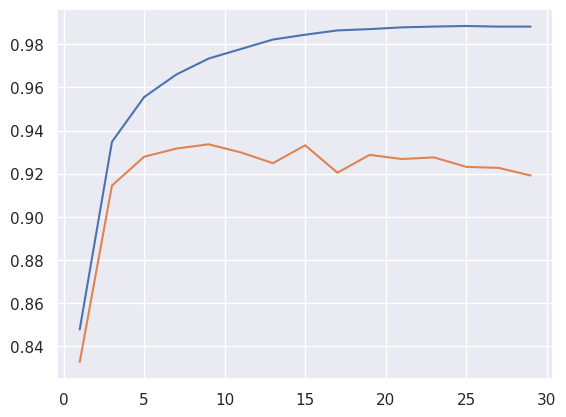

In [7]:
results_train = []
results_test = []

depths = range(1, 30, 2)
for depth in depths:
    boosting = Boosting(base_model_params={'max_depth' : depth})
    boosting.fit(x_train, y_train, x_valid, y_valid)
    results_train += [boosting.score(x_train, y_train)]
    results_test += [boosting.score(x_test, y_test)]
plt.plot(depths, results_train)
plt.plot(depths, results_test)

**Какая из моделей имеет лучшее качество? Как вы можете это объяснить?**

Модель с базовыми деревьями, максимальной глубины в районе 8 показывает наилучшее качество, т.к. после 8 деревья начинают переобучатся, из-за чего качество на тестовой выборке падает

## Задание 3. Подбираем гиперпараметры и ищем лучшую модель (3 балла)

Подберите по валидационной выборке основные гиперпараметры для вашей модели бустинга. Следует подобрать все основные параметры для самого градиентного бустинга и для самих базовых моделей. Существуют библиотеки для подбора гиперпараметров, попробуйте использовать какую-нибудь из следующих двух - [Hyperopt](https://github.com/hyperopt/hyperopt), [Optuna](https://optuna.org/).

In [170]:
import optuna

def objective(trial):
    param = {
        "n_estimators" : trial.suggest_int("n_estimators", 10, 50),
        "learning_rate" : trial.suggest_float("learning_rate", 1e-4, 1e-2, log=True),
        "subsample" : trial.suggest_float("subsample", 0.1, 0.5),
        "early_stopping_rounds" : trial.suggest_int("early_stopping_rounds", 0, 20)
    }
    base_model_params = {
        "max_depth" : trial.suggest_int("max_depth", 1, 20)
    }
    boosting = Boosting(base_model_params=base_model_params, **param)
    boosting.fit(x_train, y_train, x_valid, y_valid)
    return boosting.score(x_test, y_test)
optuna.logging.set_verbosity(optuna.logging.WARNING) # убираем сообщения об итерациях
# 3. Create a study object and optimize the objective function.
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=100,
               show_progress_bar=True # добавляет progress_bar
              ) 

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
study.best_value

In [ ]:
study.best_params

In [76]:
best_model = Boosting({'max_depth': 13}, **{'n_estimators': 27,
                                            'learning_rate': 0.003094589178242469,
                                            'subsample': 0.11599074455681223,
                                            'early_stopping_rounds': 6})
best_model.fit(x_train, y_train, x_valid, y_valid)
print(f'Train ROC-AUC {best_model.score(x_train, y_train):.4f}')
print(f'Valid ROC-AUC {best_model.score(x_valid, y_valid):.4f}')
print(f'Test ROC-AUC {best_model.score(x_test, y_test):.4f}')

Train ROC-AUC 0.9775
Valid ROC-AUC 0.9378
Test ROC-AUC 0.9357


## Задание 4. Интерпретация бустингового (2 балл)

Постройте калибровочную кривую для вашей лучшей модели бустинга. Насколько хорошо бустинг оценивает вероятности? Постройте также калибровочную кривую для логистической регрессии, сравните их между собой. Проанализируйте полученные результаты.

In [26]:
def plot_calibration_curve(y_test, preds): # функция из 4ой домашки
    bin_middle_points = []
    bin_real_ratios = []
    n_bins = 10
    for i in range(n_bins):
        l = 1.0 / n_bins * i
        r = 1.0 / n_bins * (i + 1)
        bin_middle_points.append((l + r) / 2)
        bin_real_ratios.append(np.sum(y_test[(preds >= l) & (preds < r)]) / len(y_test[(preds >= l) & (preds < r)]))
    plt.figure(figsize=(6,6))
    plt.plot(bin_middle_points, bin_real_ratios)
    plt.plot(np.arange(0, 1, 0.1), np.arange(0, 1, 0.1), color='green', linestyle='--')
    plt.ylim([-0.05, 1.05])
    plt.grid()

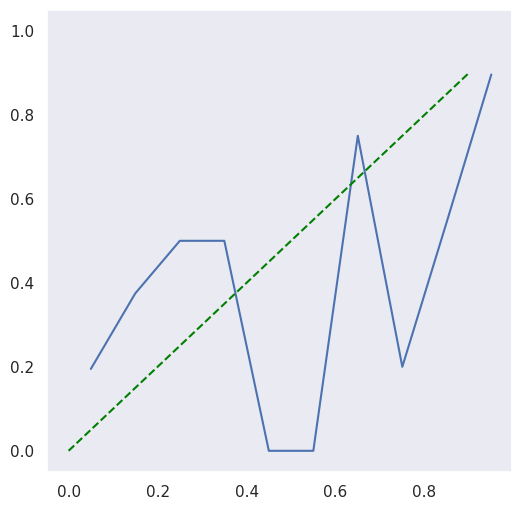

In [27]:
plot_calibration_curve((y_test + 1) / 2, best_model.predict_proba(x_test)[:, 1])

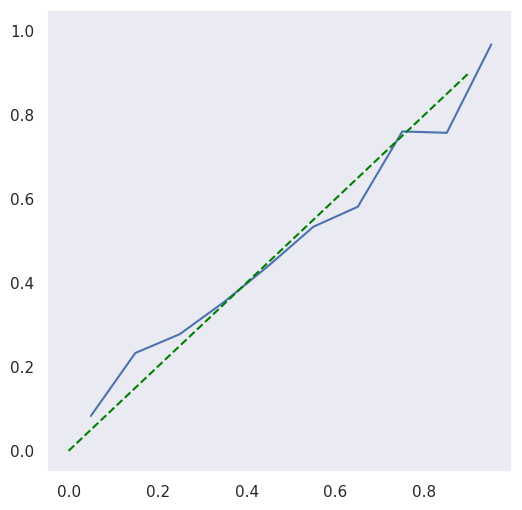

In [152]:
from sklearn.linear_model import LogisticRegression
logreg = LogisticRegression().fit(x_train, y_train)
plot_calibration_curve((y_test + 1) / 2, logreg.predict_proba(x_test)[:, 1])

Теперь попробуем оценить важность признаков для бустинга.

Поскольку наша базовая модель - это дерево из `sklearn`, мы можем вычислить важность признака отдельно для каждого дерева и усреднить (воспользуйтесь `feature_importances_` у `DecisionTreeRegressor`), после этого нормировать значения, чтобы они суммировались в единицу (обратите внимание, что они должны быть неотрицательными - иначе вы что-то сделали не так).

Допишите в вашей реализации бустинга функцию `feature_importances_` чтобы она возвращала описанные выше важности признаков.

Нарисуйте столбчатую диаграмму важности признаков. На соседнем графике нарисуйте важность признаков для логистической регрессии, для этого используйте модули весов. Сравните графики. Проанализируйте полученные результаты.

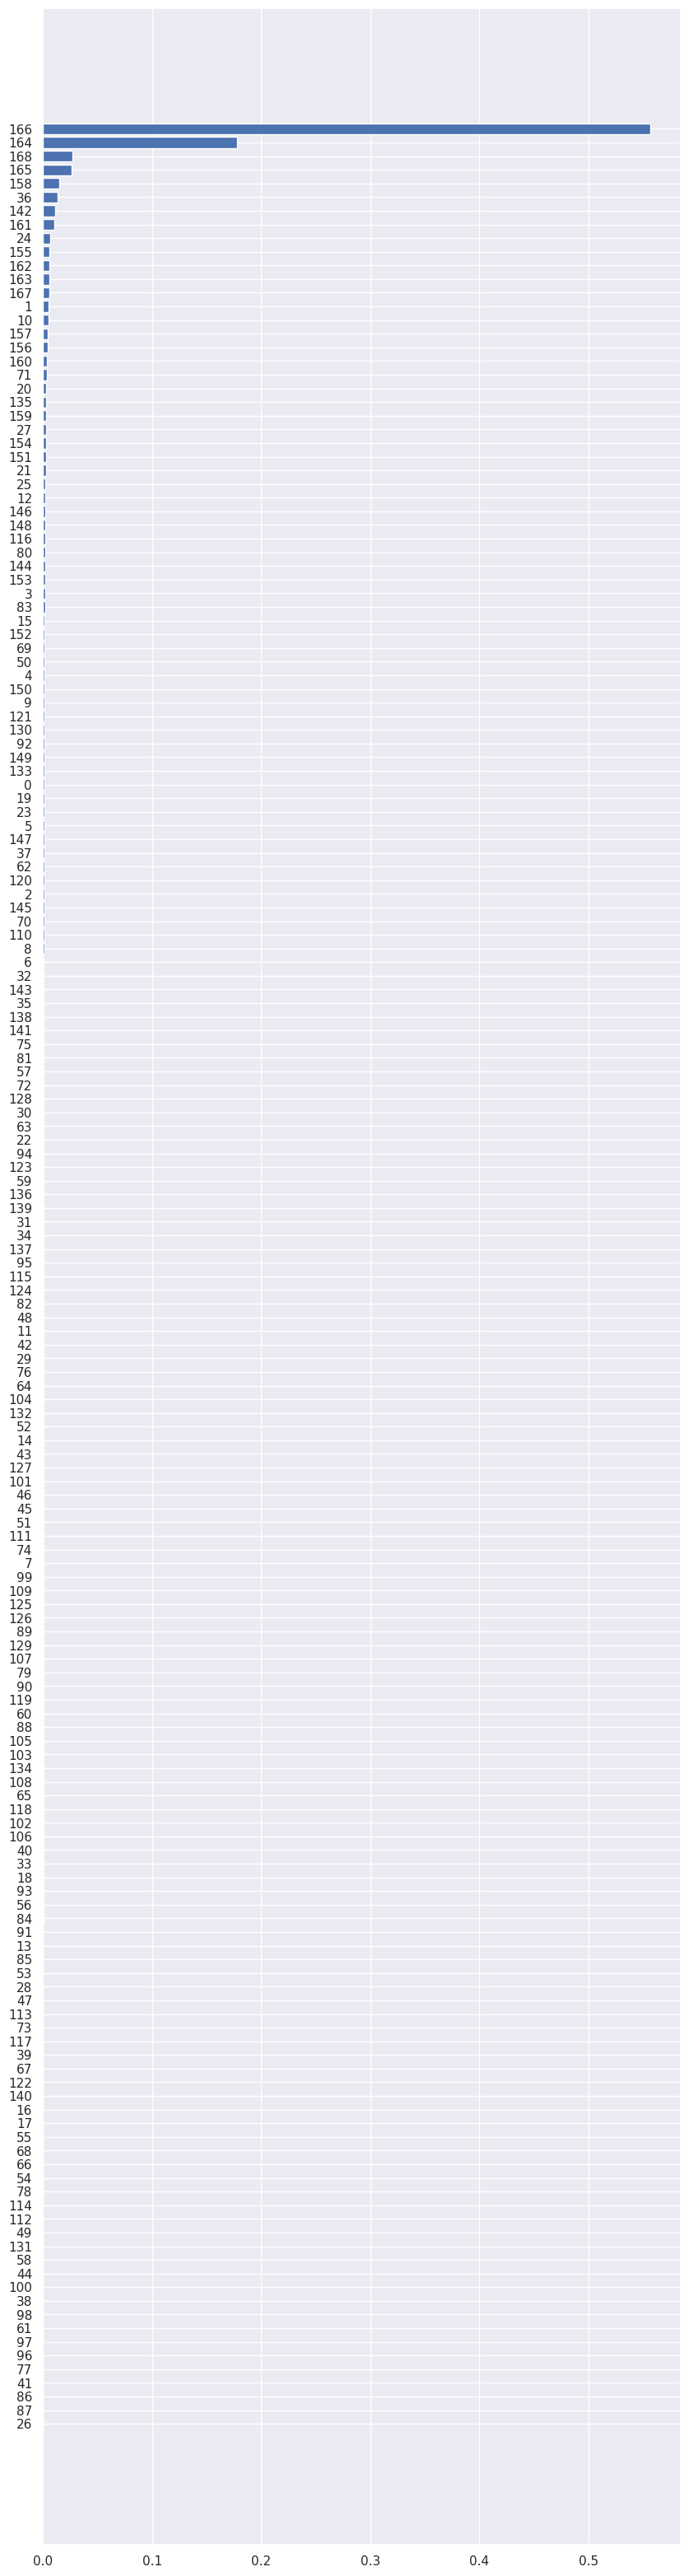

In [62]:
importances = best_model.feature_importances_

indices = np.argsort(importances)
plt.figure(figsize=(10, 40))
plt.barh(np.arange(importances.shape[0]), importances[indices])
plt.yticks(ticks=np.arange(importances.shape[0]), labels=[str(i) for i in indices])
plt.show()

In [97]:
best_ind = indices[:-60:-1]
best_ind

array([166, 164, 168, 165, 158,  36, 142, 161,  24, 155, 162, 163, 167,
         1,  10, 157, 156, 160,  71,  20, 135, 159,  27, 154, 151,  21,
        25,  12, 146, 148, 116,  80, 144, 153,   3,  83,  15, 152,  69,
        50,   4, 150,   9, 121, 130,  92, 149, 133,   0,  19,  23,   5,
       147,  37,  62, 120,   2, 145,  70])

In [98]:
best_model2 = Boosting({'max_depth': 13}, **{'n_estimators': 27,
                                            'learning_rate': 0.003094589178242469,
                                            'subsample': 0.11599074455681223,
                                            'early_stopping_rounds': 6})
best_model2.fit(x_train[:, best_ind], y_train, x_valid[:, best_ind], y_valid)
print(f'Train ROC-AUC {best_model2.score(x_train[:, best_ind], y_train):.4f}')
print(f'Valid ROC-AUC {best_model2.score(x_valid[:, best_ind], y_valid):.4f}')
print(f'Test ROC-AUC {best_model2.score(x_test[:, best_ind], y_test):.4f}')

Train ROC-AUC 0.9777
Valid ROC-AUC 0.9362
Test ROC-AUC 0.9350


Кстати, чаще всего излишние признаки могут вредить качеству бустинга. Попробуйте отфильтровать на основании диаграммы хвост наименее важных признаков и снова обучить модель (с теми же гиперпараметрами). Стало ли лучше?

**Н** Видим, что качество не на много, но все же упало(

## Задание 5 (бонус). Блендинговое (1 балл)

Реализуйте блендинг над вашей лучшей моделью и логистической регрессией. Улучшилось ли качество?

In [165]:
new_feat1 = logreg.predict_proba(x_valid)[:, 1]
new_feat2 = best_model.predict_proba(x_valid)[:, 1]
new_feat3 = logreg.predict_proba(x_test)[:, 1]
new_feat4 = best_model.predict_proba(x_test)[:, 1]

In [166]:
from scipy.sparse import vstack
spr_valid = hstack((x_valid, new_feat1[:, None], new_feat2[:, None]))
spr_test = hstack((x_test, new_feat3[:, None], new_feat4[:, None]))

In [167]:
from sklearn.svm import SVC

In [168]:
from sklearn.metrics import roc_auc_score
meta = SVC(kernel='linear')
meta.fit(spr_valid, y_valid)
roc_auc_score(y_test == 1, meta.decision_function(spr_test))

0.9101492939162965

**Н** исходя из полученного качества мой блендинг не оч, но скорее всего это еще зависит от выбора мета-модели

## Задание 6 (бонус). Катбустовое (1 балл)

Запустите [CatBoost](https://catboost.ai/en/docs/concepts/python-quickstart) на наших данных, сравните с вашей реализацией. Где получилось лучше?

**Н** Catboost на момент решения ноутбука не совместим с numpy 2.x, поэтому пришлось даунгрейдить numpy до 1.26

In [1]:
# делается это так ##########

# pip uninstall numpy
# pip install numpy==1.26

In [17]:
from catboost import CatBoostClassifier
from sklearn.metrics import roc_auc_score

cb = CatBoostClassifier(silent=True)
cb.fit(x_train, y_train)
roc_auc_score(y_test == 1, cb.predict_proba(x_test)[:, 1])

0.9416219377978754

## Социализационный бонус. Новогоднее 🎆 (0.5 балла)

Сфотографируйтесь с наряженной новогодней или рождественской ёлкой! Приложите фотографию, опишите свои впечатления, чего вы ждете от нового 2024 года?

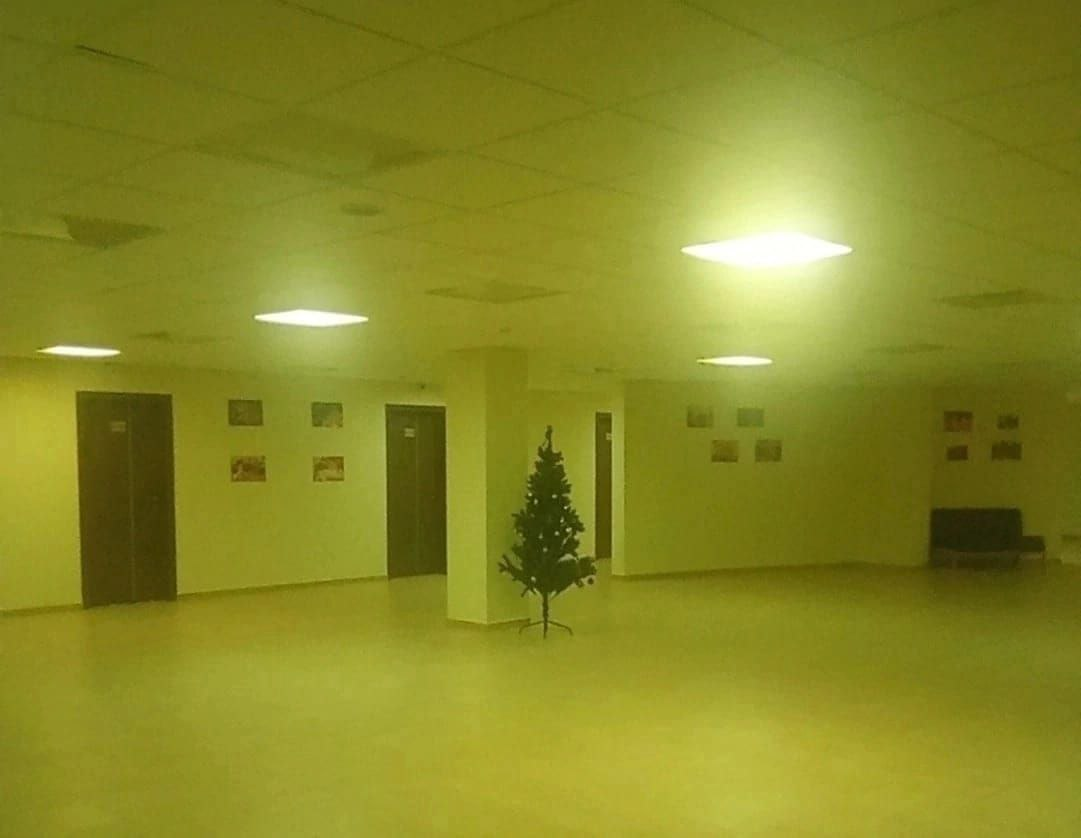